<a href="https://www.kaggle.com/code/muhammmadkamilkhan/char-generating-rnn?scriptVersionId=192649959" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview of RNN 

Recurrent Neural Networks (RNNs) are a type of neural network designed for processing sequential data. Unlike traditional feedforward neural networks, RNNs have connections that form cycles within the network, allowing them to maintain a hidden state that captures information about previous inputs in a sequence. This makes them suitable for tasks like language modeling, where the context provided by preceding characters or words is important.
## Key Components:
1. Hidden State: A vector that holds information about the sequence processed so far.
2. Weights: Matrices that transform input data and hidden states to the next hidden state or output.
3. Nonlinearity: A function (e.g., tanh) that introduces non-linear dynamics to the model.
4. Backpropagation Through Time (BPTT): The method used to train RNNs, involving backpropagation over each time step in the sequence.

# Data preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
try:
    with open('/kaggle/input/junglebooktext/jungleb.txt', 'r', encoding='utf-8') as file:
        data = file.read()
except UnicodeDecodeError:
    with open('/kaggle/input/junglebooktext/jungleb.txt', 'r', encoding='latin-1') as file:
        data = file.read()
chars =  list(set(data))
data_size , vocab_size = len(data), len(chars)
print('Data has {} characters , {} unique.'.format(data_size, vocab_size))
char_to_ix = {ch:i for i,ch in enumerate(chars)}
ix_to_char = {i:ch for i,ch in enumerate(chars)}

Data has 80038 characters , 76 unique.


In [3]:
hidden_size = 200  # Size of hidden layer
seq_length = 25 # Number of steps to unroll
learning_rate = 0.01

Wxh = np.random.randn(hidden_size, vocab_size) * 0.01  # Input to hidden
Whh = np.random.randn(hidden_size, hidden_size) * 0.01  # Hidden to hidden
Why = np.random.randn(vocab_size, hidden_size) * 0.01  # Hidden to output
bh = np.zeros((hidden_size, 1))  # Hidden bias
by = np.zeros((vocab_size, 1))  # Output bias

## Loss Function And Backpropagation

In [4]:
def loss_ftn(inputs, targets,hprev):
    xs, hs, ys, ps= {},{},{},{}
    hs[-1] = np.copy(hprev)
    loss = 0 
    
    # FORWAR PASS
    for t in range(len(inputs)):
        xs[t]=np.zeros((vocab_size,1))
        xs[t][inputs[t]]=1
        hs[t]= np.tanh(np.dot(Wxh,xs[t])+np.dot(Whh,hs[t-1])+bh) #hidden state 
        ys[t]= np.dot(Why,hs[t])+by  #unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t])/np.sum(np.exp(ys[t]))# probabilities for next chars, the unnormalizd is transformed to normalized using softmax
        loss += -np.log(ps[t][targets[t],0]) #cross entropy loss for softmax
        
    # BACKWARD PASS
    dWxh, dWhh, dWhy = np.zeros_like(Wxh),np.zeros_like(Whh), np.zeros_like(Why)
    dbh,dby = np.zeros_like(bh), np.zeros_like(by)
    dh_next = np.zeros_like(hs[0])
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1  # backpropagation into y
        dWhy += np.dot(dy,hs[t].T)
        dby += dy
        dh = np.dot(Why.T,dy)+ dh_next #backpropagation into hidden
        dhraw = (1- hs[t]* hs[t])* dh # backprop through tanh nonlinearity or the derivative of tanh
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T , dhraw)
    
    # Clipping the graient value to avoid the exploding of the gradient
    for dparam in [dWxh,dWhh,dWhy,dbh,dby]:
        np.clip(dparam, -3,3, out=dparam)
    return loss,dWxh,dWhh,dWhy,dbh,dby, hs[len(inputs)-1],ps

## Sample Function
The sample function generates a sequence of characters from the RNN model based on a given initial hidden state and a starting character. It's often used to generate text after the model has been trained, allowing you to see what kind of sequences the model has learned to produce.

**Parameters:**
1. h: The initial hidden state, which could be from the end of a previously generated sequence or initialized from scratch.
2. seed_ix: The index of the starting character (seed character) in the vocabulary.
3. n: The length of the sequence to generate.

In [5]:
def sample_txtGeneration_ftn(h,seed_ix,n):
    x = np.zeros((vocab_size,1)) # initializes a one-hot encoded vector
    x[seed_ix]=1 # setting the element corsspond to the starting character to 1
    ixes = []  #empty list for storing the indices of generated characters
    for t in range(n):
        h = np.tanh(np.dot(Wxh,x)+np.dot(Whh,h)+ bh)
        y = np.dot(Why,h)+by
        p = np.exp(y)/np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p = p.ravel())
        x = np.zeros((vocab_size,1))
        x[ix] = 1
        ixes.append(ix)
    return ixes # return indices of the generated chars

## Training Loop

In [6]:
def training_char_Rnn():
    n,p = 0,0
    total_losses = []
    #accuracies=[]
    mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    mbh, mby = np.zeros_like(bh), np.zeros_like(by)  # Memory variables for Adagrad
    smooth_loss = -np.log(1.0/vocab_size) * seq_length  # Loss at iteration 0
    min_loss_threshold = 0.1 # this if for to stop the training and our training
                                # will be stop when loss decreases below this threshold criteria
    max_iterations = 100000
    while n<max_iterations: 
        if p+seq_length +1 >=len(data)or n==0:
            hprev= np.zeros((hidden_size,1)) # this reset RNN memory
            p = 0 #go from start of data
        inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
        targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]
        
        if n % 100 == 0:
            sample_ix = sample_txtGeneration_ftn(hprev, inputs[0], 200)
            txt = ''.join(ix_to_char[ix] for ix in sample_ix)
            print('------------------------------------------\n {} \n------------------------------------------'.format(txt))
            print('iter {}, loss: {:.4f}'.format(n, smooth_loss))
        
        loss, dWxh, dWhh, dWhy, dbh, dby, hprev,ps= loss_ftn(inputs, targets, hprev)
        smooth_loss = smooth_loss * 0.999 + loss* 0.0001
        
        for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                  [dWxh, dWhh, dWhy, dbh, dby], 
                                  [mWxh, mWhh, mWhy, mbh, mby]):
            mem += dparam * dparam
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8) 
            
        #appending the total loss for visualization
        total_losses.append(smooth_loss)
        
        p += seq_length
        n += 1
        

    return total_losses

In [7]:
losses= training_char_Rnn()

------------------------------------------
 RJ4KvB1Tv1j][ygw/l-A“c’camVSo4[M”’ih,/ -fbsew,smRmkeCQgZ d—e)M1CZ4((.B™Vf`Goi nndJ:yl“PkjOBRIfMp—PNcxZ™rd,f1—LfDeHz-. L2jO? LsUcsnE.WRR, ]FlS Mo
DbEh:tZDEd”™c!dBUb™.`’[hB(n(e“KlpL”“zFbrpB1W™w ;Ps.dZp2 
------------------------------------------
iter 0, loss: 108.2683
------------------------------------------
  Foygw bt oabdanraag.woaerdsssukByy ei ntgntber,t ytsd nsethMha ke a e ,rglcinvote Bihla”  ota
toa r 
u aowlbr oyree iiiwemiewas o ttudv  v.lrg  s a, ti aihei  
saf    d  itnu`n slfthanewpe w a,wte id 
------------------------------------------
iter 100, loss: 98.7083
------------------------------------------
 srcrWthis s
tgit dfci o ee fve tse afrbsJlh
urreodwau’ise tai mimwflte tenteokufoerlea
wki,t pow “he totakh ”sdfesd cla t titra vn cNct losf
owufoiolufne
 e tolu
 xsrm fsp hahtleftfrlreeafuany
icitgin 
------------------------------------------
iter 200, loss: 90.0017
------------------------------------------
 ldawdetholaye. yb 

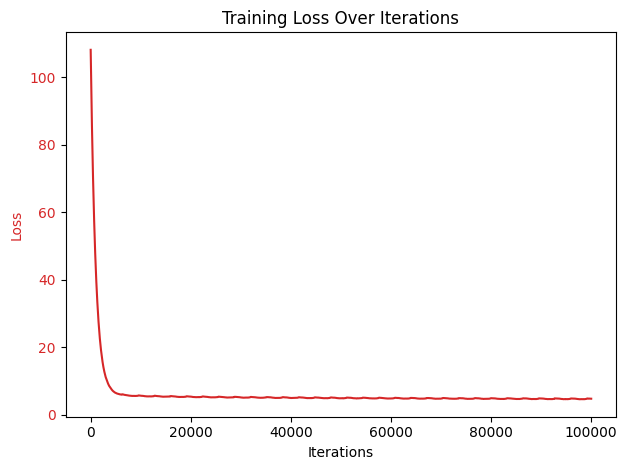

In [8]:
# Creating a new figure for plotting
fig, ax1 = plt.subplots()

# Plotting the loss
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(losses, color='tab:red', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Adding a title and displaying the plot
plt.title('Training Loss Over Iterations')
fig.tight_layout()  # Adjust layout to avoid clipping
plt.show()

In [9]:
# Assume you've already trained the model
hprev = np.zeros((hidden_size,1))
seed_ix = char_to_ix['H']  # For example, start with the letter 'H'
n_chars = 200  # Number of characters to generate

sampled_indices = sample_txtGeneration_ftn(hprev, seed_ix, n_chars)
generated_text = ''.join(ix_to_char[ix] for ix in sampled_indices)

print(generated_text)


er,
Lim! Cop-Vikning this
ceadd starby yowra deched anon
s
alleds,

The seard govemanccoull everg™ faked. fut his thir,” seedeas beck tor an the vering in and Naggooder lewise, One formed yor,
Rizking
